# MCMC Tutorial Part2A -- Normal Distribution Fitting

**Authors:** John Letey and Mingxuan Zhang

<br>

In [1]:
# All of our imports that we need
import pandas as pd
import numpy as np
import scipy.stats as stats
import sys
from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline
# Use 95% of the screen
from IPython.display import display, HTML, Latex
display(HTML("<style>.container { width:95% !important; }</style>"))

## Generate Synthetic Data

For this synthetic data, the mean is 11.91 and the std is 9.97


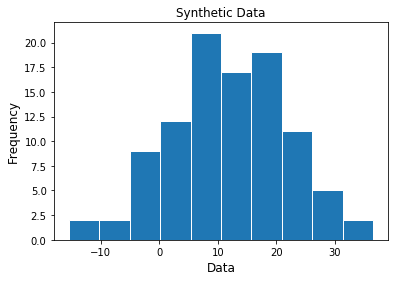

In [6]:
# Generate the syntheic data

ustar = 10
sstar = 10
data_meas = generate_synthetic_data(ustar, sstar)

## Likelihood Function


In [7]:
def likelihood(parameters, data_meas):
    u, s = parameters                                                 
    prod = 1
    for i in range(len(data_meas)):
        pdf = stats.norm.pdf(x=data_meas[i], loc=u, scale=s)
        if (pdf==0):
            return -np.inf
        prod += np.log(pdf)
    return prod    

## Prior Distribution


In [8]:
def prior(parameters):
    u, s = parameters
    pdf = stats.norm.pdf(x=u, loc=0, scale=100)
    if s >= 1000 or s <= 0 or pdf==0:
        return -np.inf
    else:
        return np.log(pdf)+np.log(1/1000)

## Posterior Distribution/Posterior Score

In [9]:
def logpost(parameters, data_meas):
    pi = prior(parameters)
    if pi == -np.inf:
        return -np.inf
    L = likelihood(parameters, data_meas)
    return L + pi

## Adaptive Metropolis-Hastings Algorithm

In [10]:
# set up the function to update the covariance matrix

eps = 0.0001
d = 2                                                                                                                                                                                                                                                                                                         
I_d = np.identity(d)
S_d = (2.4)**2/d
def update_cov(X):
    cov = np.cov(X)
    return S_d*cov + I_d*eps*S_d

In [11]:
# First, let's set up some classes for our Metropolis-Hastings algorithm

class State: 
    def __init__(self, state, value):
        self.state = state 
        self.value = value 

class ProblemMCMC: 
    def __init__(self, initial, logposterior, stepsize, data_measa, t0):
        self.current = initial 
        self.logpost = logposterior 
        self.stepsize = stepsize 
        self.data_meas = data_meas
        self.t0 = t0
        
    def random_move(self, t, X):
        if (t <= self.t0):
            next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        else:
            cov = update_cov(X)
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
        return next_move, self.logpost(next_move, self.data_meas)

In [12]:
def Adaptive_mcmc(problem, n_iter):
    u, s = [problem.current.state[0]], [problem.current.state[1]]
    lpost = [problem.current.value]
    n_accept = 0
    S = 0
    for t in range(n_iter):
        S += 1
        nextMove, nextValue = problem.random_move(t, [u, s])
        delta_obj = np.exp(nextValue - lpost[-1])
        if delta_obj > 1:
            # the proposed move is an improvement, so accept w.p. 1
            n_accept += 1
            u.append(nextMove[0])
            s.append(nextMove[1])
            lpost.append(nextValue)
            problem.current.state = nextMove
            problem.current.value = nextValue
        else:
            # the proposed move is worse; accept with probability exp[delta_obj/T]
            p_accept = delta_obj
            accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
            if accept:
                n_accept += 1
                u.append(nextMove[0])
                s.append(nextMove[1])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                u.append(u[-1])
                s.append(s[-1])
                lpost.append(lpost[-1])

    return (u, s, lpost, n_accept/S)

In [13]:
mcmc_chains, ar = sequences_generator(mcmc=Adaptive_mcmc, problem=ProblemMCMC, m=3, data_meas=data_meas, logpost=logpost, t0=1000, n_iter=8000)

/Users/john/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


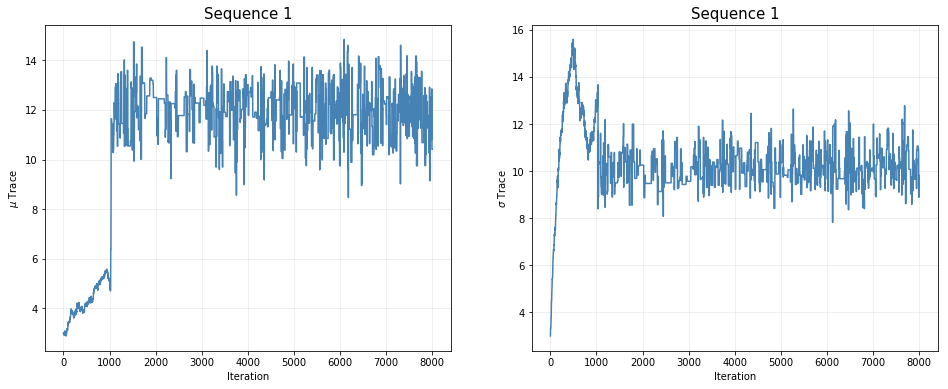

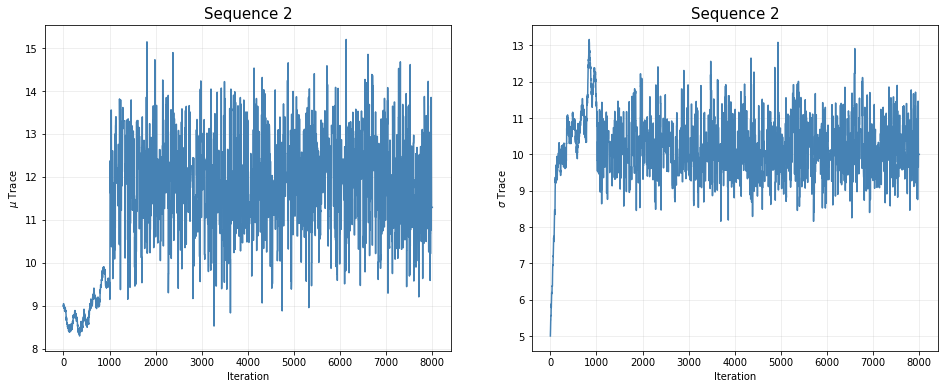

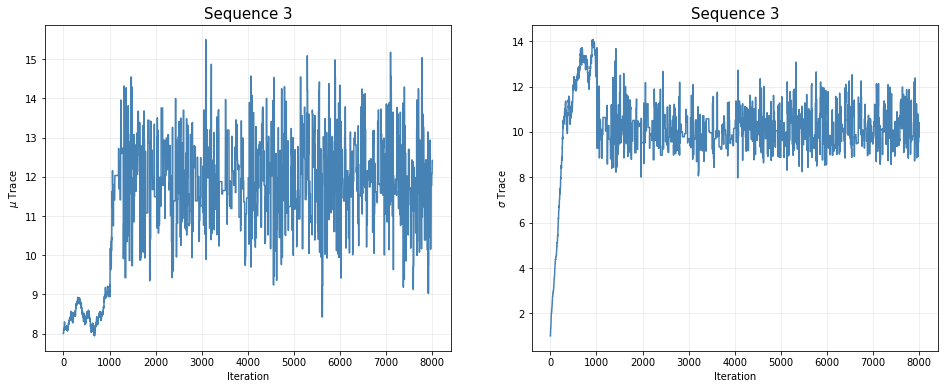

In [14]:
plot_sequences(mcmc_chains)

## Convergence/Stationarity Diagnostics

In [15]:
def GR_diag(parameter, interval=100, start=100, plot=True):
    end = len(parameter[0])
    m = len(parameter)
    GR_result = []
    x_range = []
    for n in range(start, end, interval):
        x_range.append(n)
        sequences = []
        for i in range(m):
            sequences.append(parameter[i][:n])
        GR_result.append(psrf(sequences))
    if plot:
        plt.figure(figsize=(14, 6))
        plt.scatter(x=x_range, y=GR_result)
        plt.xlabel('iteration', fontsize=14)
        plt.ylabel('potential scale reduction fator', fontsize=14)
        plt.title('Gelman & Rubin Diagnostic', fontsize=14)
        plt.show()
    return GR_result

def psrf(sequences):
    u = [np.mean(sequence) for sequence in sequences]
    s = [np.var(sequence, ddof=1) for sequence in sequences]
    m = len(sequences)
    n = len(sequences[0])
    U = np.mean(u)
    B, W = 0, 0
    for i in range(m):
        B += (u[i] - U)**2
        W += s[i]
    B = (B*n)/(m-1)
    W = W/m
    Var = (1-(1/n))*W + (B/n)
    return np.sqrt(Var/W)

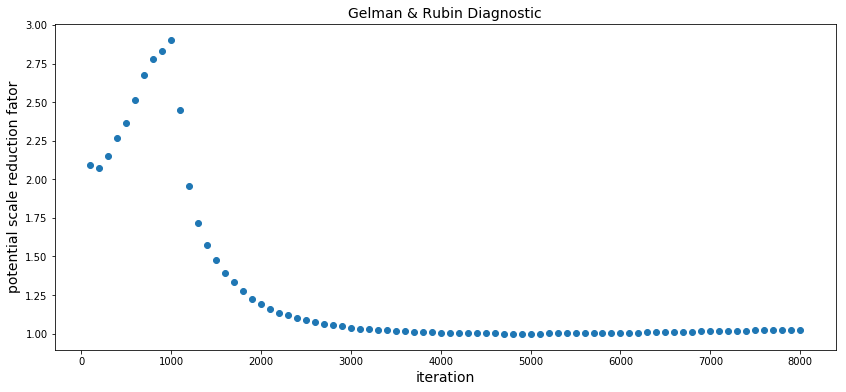

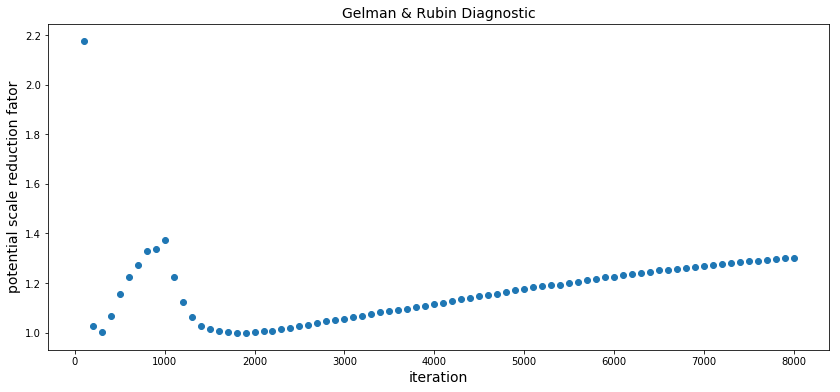

In [16]:
GR_u = GR_diag(mcmc_chains[:][0])
GR_s = GR_diag(mcmc_chains[:][1])

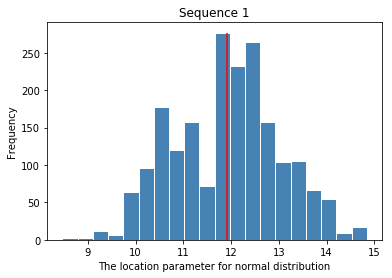

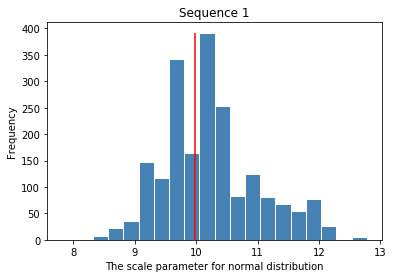

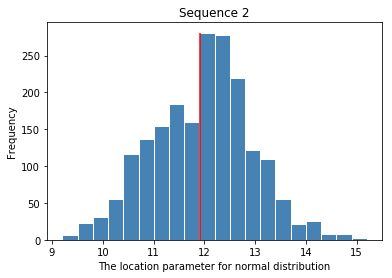

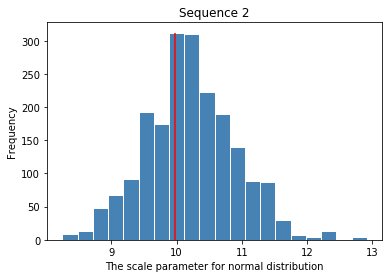

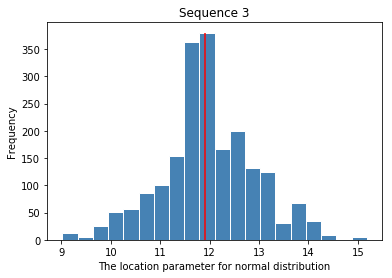

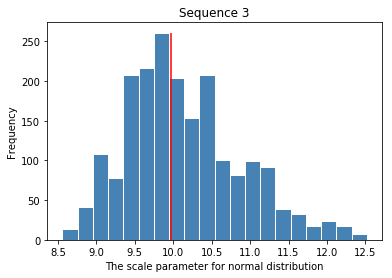

In [17]:
burnin = 6000
bestfit = [np.mean(data_meas), np.std(data_meas)]
for i in range(len(mcmc_chains)):
    plt.hist(mcmc_chains[i][0][burnin:], facecolor="steelblue", edgecolor="white", bins=20)
    freq1, bin1 = np.histogram(mcmc_chains[i][0][burnin:], bins=20)
    plt.vlines(x=bestfit[0], ymin=0, ymax=max(freq1), color="red")
    plt.xlabel("The location parameter for normal distribution")
    plt.ylabel("Frequency")
    plt.title("Sequence {0}".format(i+1))
    plt.show()
    plt.hist(mcmc_chains[i][1][burnin:], facecolor="steelblue", edgecolor="white", bins=20)
    freq2, bin2 = np.histogram(mcmc_chains[i][1][burnin:], bins=20)
    plt.vlines(x=bestfit[1], ymin=0, ymax=max(freq2), color="red")
    plt.xlabel("The scale parameter for normal distribution")
    plt.ylabel("Frequency")
    plt.title("Sequence {0}".format(i+1))
    plt.show()

## Thinning


In [18]:
def ACF(X, end=200, interval=1, plot=True):
    N = len(X)
    acf = []
    x_range = []
    for a in range(0, end, interval):
        x_range.append(a)
        acf.append(np.corrcoef(X[a:], X[:N-a])[0][1])
    if plot:
        plt.figure(figsize=(8, 6))
        plt.stem(x_range, acf)
        plt.xlabel('Lag', fontsize=12)
        plt.ylabel('ACF', fontsize=12)
        plt.show()
    return acf

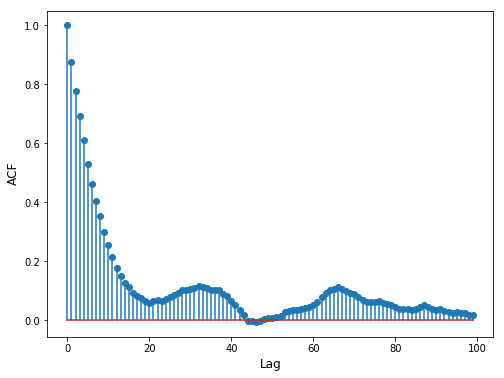

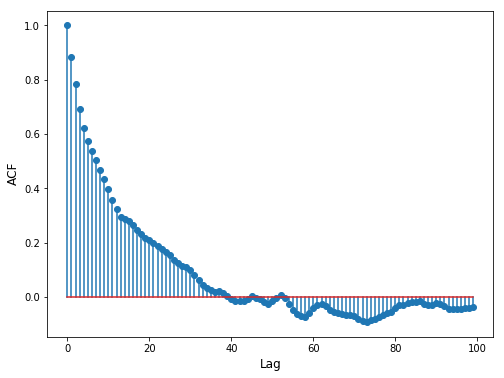

In [19]:
# set up

burnin = 6000
acf = []
for i in range(len(mcmc_chains[:][0])):
    acf.append(ACF(mcmc_chains[:][0][i][burnin:], end=100))

## Helper Functions:

In [2]:
# Function to generate synthetic data (and plot it)

def generate_synthetic_data(ustar, sstar, plot=True):
    np.random.seed(3202) # set the seed for random sampling.
    data_meas = stats.norm.rvs(loc=ustar, scale=sstar, size=100)
    if plot:
        plt.figure(figsize=(6, 4))
        plt.hist(data_meas, edgecolor='white')
        plt.xlabel('Data', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title('Synthetic Data', fontsize=12)
    print ('For this synthetic data, the mean is {:.2f} and the std is {:.2f}'.format(np.mean(data_meas), np.std(data_meas)))
    return data_meas

In [3]:
def sequences_generator(mcmc, problem, m, data_meas, logpost, t0=1, stepsize=[0.001, 0.01], n_iter=4000):
    # Generate the problems
    problems = []
    bestfit = (np.mean(data_meas), np.std(data_meas))
    for i in range(m):
        ui = np.random.randint(low=1, high=20)
        si = np.random.randint(low=1, high=16)
        theta =[ui, si]
        state = State(theta, logpost(theta, data_meas))
        problems.append(problem(state, logpost, stepsize, data_meas, t0))
    # Run the algorithm on the problems
    ar, mcmc_chains = [], []
    for i in range(m):
        u, s, l, r = mcmc(problems[i], n_iter)
        mcmc_chains.append([u, s])
        ar.append(r)
    # Return our output
    return mcmc_chains, ar

In [4]:
def plot_sequences(mcmc_chains):
    for i in range(len(mcmc_chains)):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
        ax[0].plot(mcmc_chains[i][0], color="steelblue");
        ax[0].set_xlabel("Iteration");
        ax[0].set_ylabel("$\mu$ Trace");
        ax[0].set_title("Sequence {}".format(i+1), fontsize=15);
        ax[0].grid(alpha=0.25);
        ax[1].plot(mcmc_chains[i][1], color="steelblue");
        ax[1].set_xlabel("Iteration");
        ax[1].set_ylabel("$\sigma$ Trace");
        ax[1].set_title("Sequence {}".format(i+1), fontsize=15);
        ax[1].grid(alpha=0.25);

In [5]:
def plot_graph_mu(mcmc_chain):
    mu = mcmc_chain[0]
    cor, r, flag = [], None, True
    for lag in range(1, 1500):
        X, Y = [], []
        X = mu[:len(mu) - lag]
        Y = mu[lag:]
        cor.append(np.corrcoef(X, Y, rowvar=False)[0][1])
        if flag and cor[lag - 1] <= 0.05:
            flag = False
            r = lag
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4));
    ax.plot(range(1, 1500), cor, color="steelblue", lw=2.0);
    ax.plot([r, r], [-0.2, 1], color="gray", lw=1.5);
    ax.grid(alpha=0.25);
    ax.set_title('$\mu$ Correlation');
    ax.set_xlabel('Lag');
    ax.set_ylabel('Correlation');
    plt.xlim([0,300]);
    return r

def plot_graph_sigma(mcmc_chain):
    sigma = mcmc_chain[1]
    cor, r, flag = [], None, True
    for lag in range(1, 1500):
        X, Y = [], []
        X = sigma[:len(sigma) - lag]
        Y = sigma[lag:]
        cor.append(np.corrcoef(X, Y, rowvar=False)[0][1])
        if flag and cor[lag - 1] <= 0.05:
            flag = False
            r = lag
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4));
    ax.plot(range(1, 1500), cor, color="steelblue", lw=2.0);
    ax.plot([r, r], [-0.2, 1], color="gray", lw=1.5);
    ax.grid(alpha=0.25);
    ax.set_title('$\sigma$ Correlation');
    ax.set_xlabel('Lag');
    ax.set_ylabel('Correlation');
    plt.xlim([0,300]);
    return r